# Gammapy IPython notebook : Fermi-LAT Vela region model

This notebook demonstrates how to simulate Fermi data with gammapy. We choose the Vela region as example.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
from astropy.units import Quantity
from astropy.io.fits import ImageHDU
from astropy.coordinates import Angle
from astropy.modeling.models import Gaussian2D
from astropy.convolution.utils import discretize_model
from astropy.convolution import convolve
from aplpy import FITSFigure

In [2]:
from gammapy.datasets import FermiVelaRegion
from gammapy.morphology import Shell2D
from gammapy.irf import EnergyDependentTablePSF

In [3]:
# Get background model from Fermi diffuse model
energy_range = Quantity([10, 500], 'GeV')
fermi_diffuse = FermiVelaRegion.diffuse_model()
flux_bkg = fermi_diffuse.integral_flux_image(energy_range)

# Define source model
vela_junior = Shell2D(amplitude=3E-6, x_0=-93.72, y_0=-1.24, r_in=1, width=0.5, normed=True)
vela_x = Gaussian2D(amplitude=7.5E-7, x_mean=-96.14, y_mean=-3.09, x_stddev=0.6, y_stddev=0.6)

# Get coordinates from background reference 
coord = flux_bkg.coordinates()
glon = coord.l.deg
glat = coord.b.deg

# Compute model flux image
flux = vela_x(glon, glat) + vela_junior(glon, glat) + flux_bkg.data

In [4]:
from astropy.coordinates import Angle

# Get PSF
fermi_psf = FermiVelaRegion.psf()

# Assume constant exposure. The value is choosen that we only get a few counts per bin.
exposure = Quantity(0.1E8, 'cm2 s sr')

# Convolve with psf
pix_size = Angle(0.125, 'deg')
psf = fermi_psf.table_psf_in_energy_band(energy_range).kernel(pix_size)
flux_psf_convolved = convolve(flux, psf.value, boundary='wrap')

counts = (flux_psf_convolved) * exposure.value
counts = np.random.poisson(counts)

In [5]:
# TODO: images below should be flipped left-right!!!
# flux_bkg.wcs.wcs.cdelt[0] = 0.125
header = flux_bkg.wcs.to_header()

# Compute flux and counts images


In [6]:
def format_axes(fig):
    """Format figure axes labels and ticks nicely"""
    fig.axis_labels.set_xtext('Galactic longitude [deg]')
    fig.axis_labels.set_ytext('Galactic latitude [deg]')
    fig.tick_labels.set_xformat('ddd.')
    fig.tick_labels.set_yformat('ddd.')
    fig.tick_labels.set_font(size=16)
    fig.axis_labels.set_font(size=16)
    fig.axis_labels.set_ypad(15)
    fig.axis_labels.set_xpad(15)

def format_colorbar(fig):
    fig.colorbar.set_axis_label_font(size=20)
    fig.colorbar.set_font(size=16)
    fig.colorbar.set_axis_label_pad(15)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/artist.py:224: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


INFO: Auto-setting resolution to 19.2 dpi [aplpy.core]


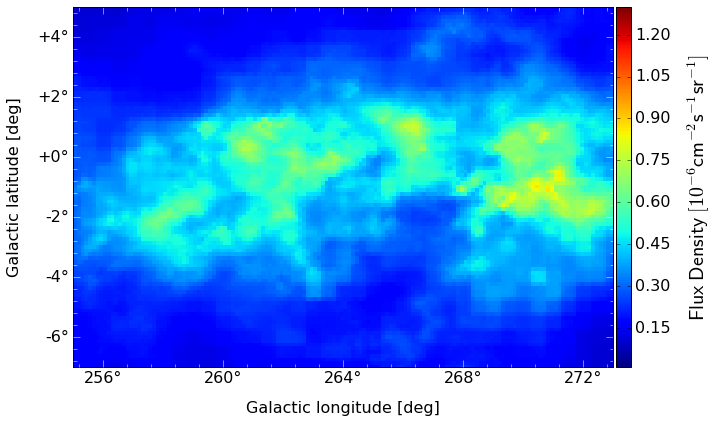

In [7]:
# Plot flux image
fig = FITSFigure(ImageHDU(1e6 * flux, header))
fig.recenter(264, -1, width=18, height=12)
fig.show_colorscale(vmin=1e-2, vmax=1.3e-0)
format_axes(fig)
fig.add_colorbar()
format_colorbar(fig)
fig.colorbar.set_axis_label_text('$\mathsf{Flux\ Density\ [10^{-6} cm^{-2} s^{-1} sr^{-1}]}$')
fig.save('fermi_vela_model_flux.pdf')

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/artist.py:224: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


INFO: Auto-setting resolution to 19.2 dpi [aplpy.core]


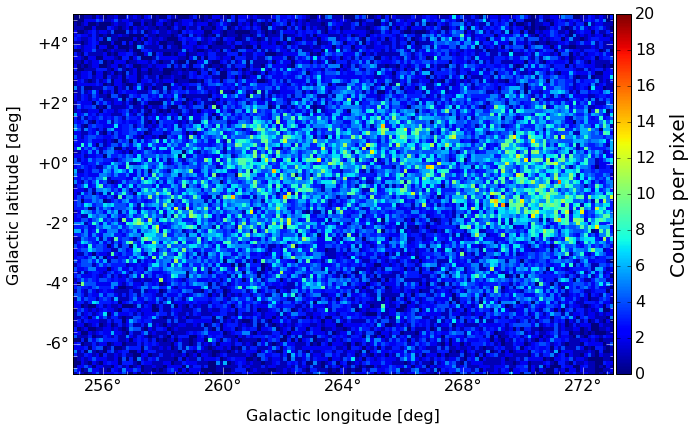

In [8]:
# Plot counts image
fig = FITSFigure(ImageHDU(counts, header=header))
fig.recenter(264, -1, width=18, height=12)
fig.show_colorscale(vmin=0, vmax=20)
format_axes(fig)
fig.add_colorbar()
format_colorbar(fig)
fig.colorbar.set_axis_label_text('Counts per pixel')
fig.save('fermi_vela_model_counts.pdf')